# Week 4

In [4]:
import sys
import scipy
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import cvxpy as cp

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
sns.set()
register_matplotlib_converters()
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, GridSearchCV
from scipy.optimize import minimize
from pandas_datareader import data 

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import ml_asset_kit as mla
sys.path.append("../")
import edhec_risk_kit as erk

In [9]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

# Regime-based Simulations and Multi-Period Portfolio Models

We will introduce the concept of **economic and market regimes**, demonstrate the significance of regime identification, evaluate the performance of regime identification methods.

## Introduction to Economic Regimes

A **regime** is a period of time in which the characteristics of market performance and related economic activity are reasonably stable. 

For better analysis of the market, we would like to categorize historical periods into a small number of regimes and evaluate each regime separately.

Let us plot the historical performance of the **US stock market index** (S&P 500) with regimes that we have determined (we will learn how to determine the regimes later):

In [10]:
asset_data = pd.read_csv("data/Assets_7.csv", index_col=0, header=0,parse_dates=[0])
asset_data.index = pd.to_datetime(asset_data.index,format="%Y-%m").to_period("M")
asset_data.head()

,US Equities,World Equities,US Treasuries,High Yield,Real Estate,Commodities,Corp Bonds,T-bill,TIPS,Regime-5,Regime-7,Regime-9
1985-01,3.69,443.231,100.0000,112.905,382.65,769.53,245.62,564.0916,0.30%,1,1,1
1985-02,3.99,455.868,101.9243,117.185,404.31,785.96,252.75,567.9944,-1.12%,1,1,1
1985-03,4.11,451.672,100.1330,118.672,410.96,774.00,246.33,571.6528,1.61%,1,1,1
1985-04,4.08,485.608,102.0311,119.185,408.20,802.77,251.11,575.8523,2.37%,1,1,1
1985-05,4.03,484.414,104.1377,121.356,408.57,774.58,256.72,579.6807,5.26%,1,1,1


In [11]:
# compute returns
rets = erk.compute_returns( asset_data.iloc[:,range(8)] )
rets = pd.concat([rets, asset_data.iloc[:,[8,9,10,11]]], axis=1).dropna() # dropping first row with NaN rets
rets.head()

,US Equities,World Equities,US Treasuries,High Yield,Real Estate,Commodities,Corp Bonds,T-bill,TIPS,Regime-5,Regime-7,Regime-9
1985-02,0.081301,0.028511,0.019243,0.037908,0.056605,0.021351,0.029029,0.006919,-1.12%,1,1,1
1985-03,0.030075,-0.009204,-0.017575,0.012689,0.016448,-0.015217,-0.025401,0.006441,1.61%,1,1,1
1985-04,-0.007299,0.075134,0.018956,0.004323,-0.006716,0.037171,0.019405,0.007346,2.37%,1,1,1
1985-05,-0.012255,-0.002459,0.020647,0.018215,0.000906,-0.035116,0.022341,0.006648,5.26%,1,1,1
1985-06,0.064516,0.040245,0.048570,0.042363,0.027241,0.004351,0.063610,0.006858,3.97%,1,1,1


In [12]:
# separate dataframe with respect to returns from a regular and crash regime given a regime vector
regime_name = "Regime-5"
rets_g = rets[rets[regime_name]==1]
rets_c = rets[rets[regime_name]==-1]

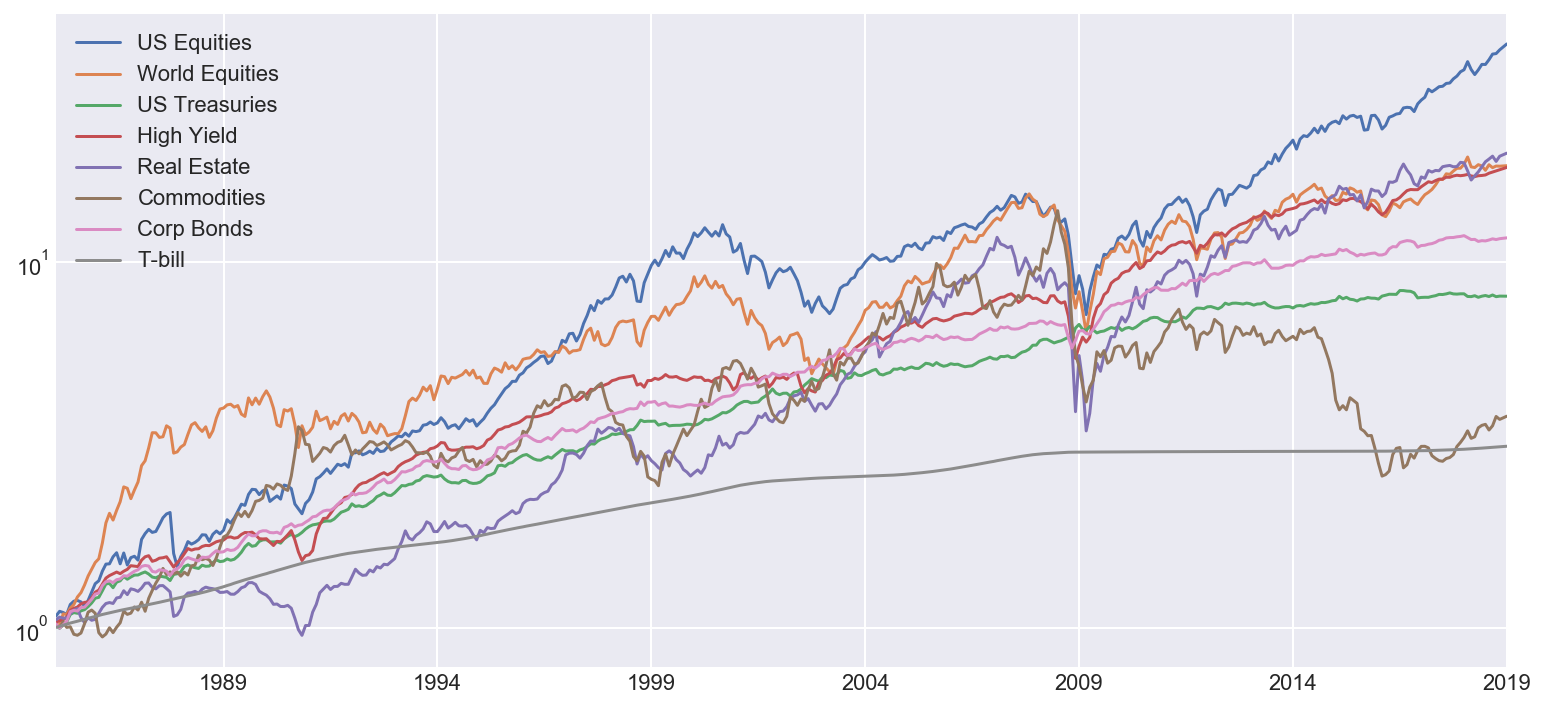

In [13]:
# plot asset wealths
( 1 + rets.iloc[:,range(8)] ).cumprod().plot(grid=True, figsize=(13,6), logy=True)
plt.show()

In [14]:
erk.summary_stats(rets.iloc[:,range(8)], risk_free_rate=0.0, periods_per_year=12)

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
US Equities,0.114126,0.155216,0.735270,-0.848029,6.249882,0.105823,0.070790,-0.530930
World Equities,0.089324,0.172688,0.517258,-0.402266,4.263287,0.113194,0.077762,-0.581763
US Treasuries,0.063357,0.046847,1.352412,0.238472,4.245303,0.022563,0.015725,-0.052445
High Yield,0.088982,0.082462,1.079061,-0.823557,11.658134,0.054620,0.032802,-0.333846
Real Estate,0.091857,0.189075,0.485823,-0.310908,19.034763,0.121518,0.067865,-0.703818
Commodities,0.040027,0.202868,0.197304,-0.407513,4.983119,0.133001,0.095442,-0.811461
Corp Bonds,0.074893,0.054117,1.383913,-0.360710,6.263009,0.029775,0.020041,-0.156373
T-bill,0.034262,0.007555,4.535324,0.168063,1.810217,-0.000017,0.000716,0.000000


In [15]:
#asset_name = "High Yield"
#asset_name = "US Treasuries"
#asset_name = "T-bill"
asset_name = "US Equities"

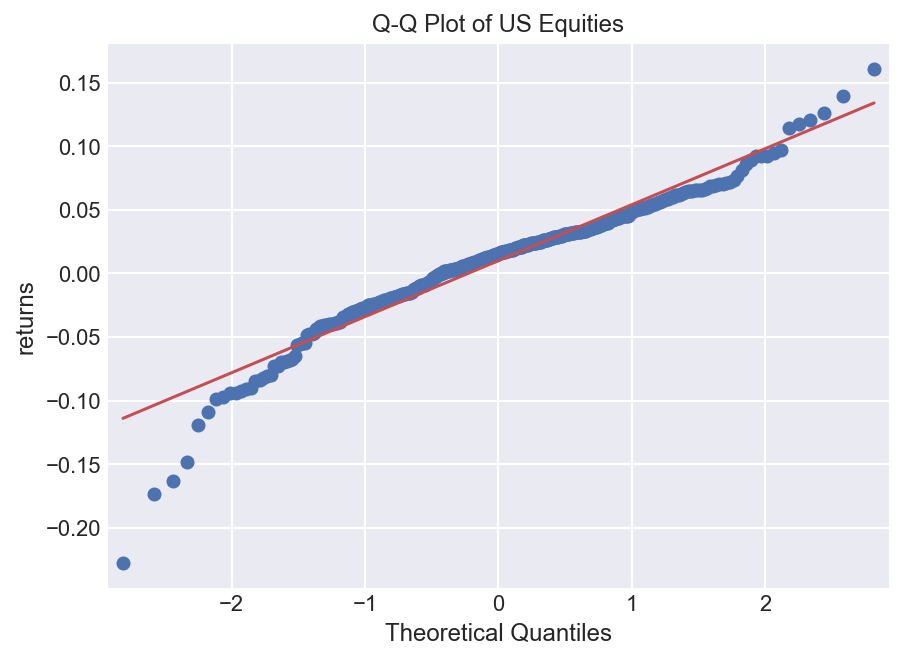

In [16]:
# Quantile-Quantile plot of assets
mla.qqplot(rets[asset_name], linetype="r")

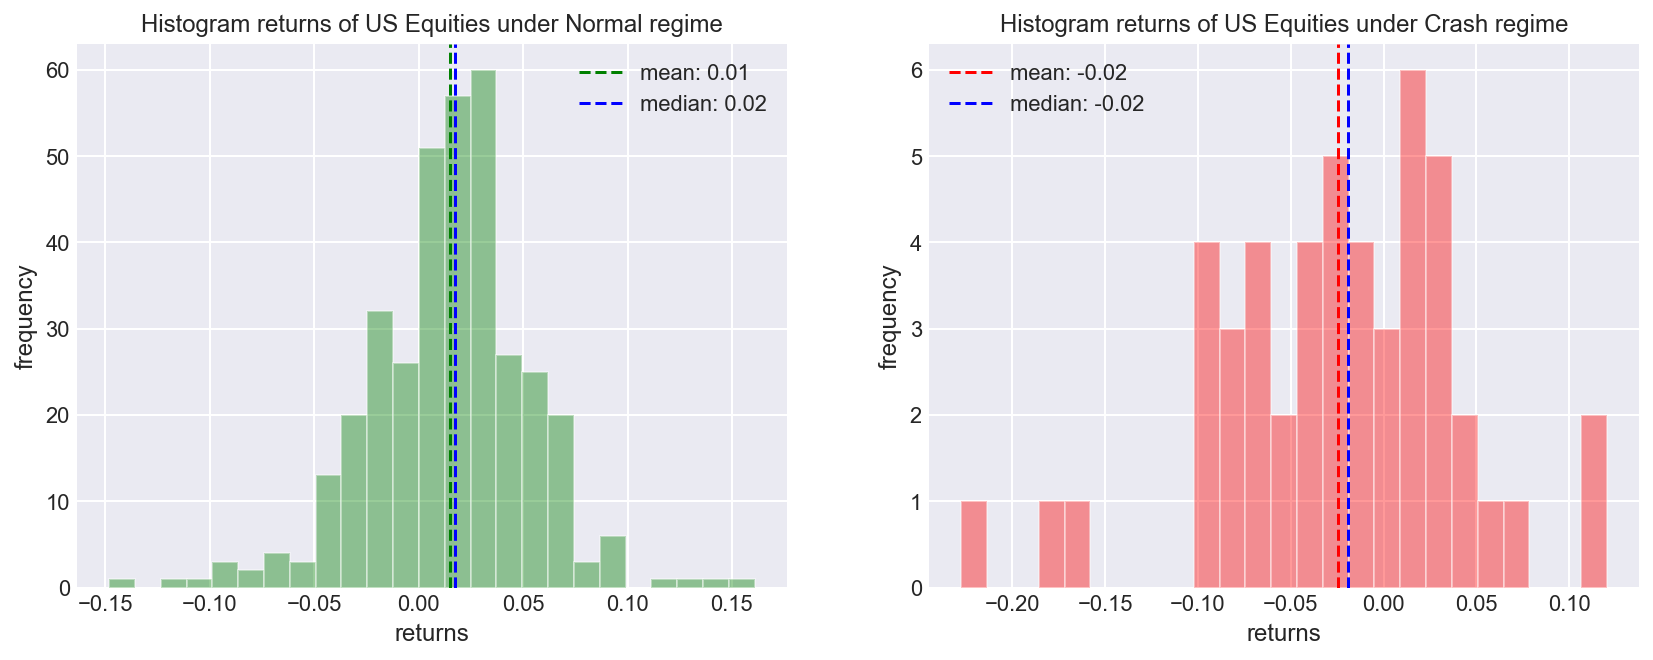

In [17]:
# Histogram returns of normal and crash regimes 
regime = rets["Regime-5"]
asset_rets = rets[asset_name]
ax = mla.regime_hist(asset_rets, regime)

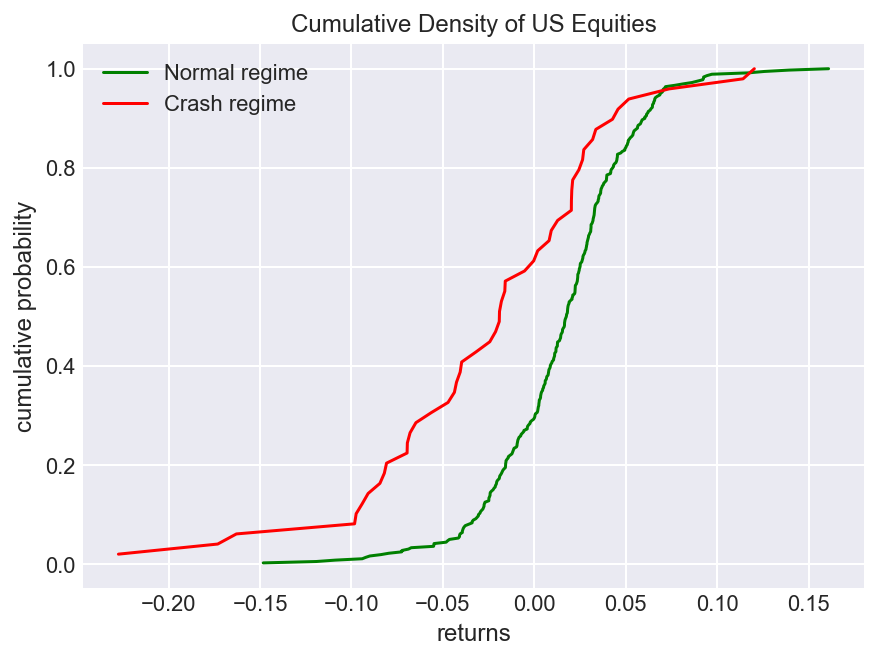

In [18]:
# Cumulative Distribution functions plot of the normal and crash regimes
ax = mla.regime_plot_cdf(rets_g[asset_name], rets_c[asset_name])

We can observe that the monthly return distribution of World Equities is very different under growth regime or contraction regime. 


## Identification of Regimes 

A **regime analysis** is significant in asset allocation and asset-liability management for long-term investors because of **the contagion** and related effects during crash periods: **the correlation between risky assets and volatility will greatly increase during the crash periods**, thus creating severe difficulty in risk management and protecting investor capital with traditional portfolio models.

Many existing methods are based on econometric models which assume a fixed structural model. However, financial return or macroeconomic data tends to be noisy and affected by myriad of factors. The state-of-the-art approach discussed in Mulvey and Liu (2016), **trend-filtering**, is non-parametric, data-driven and model-free. The algorithm was first introduced by Kim et al. (2009) and generalised in Tibshirani (2014).

In this part, we will implement the algorithm to obtain regimes of U.S. equity. First, we need the relevant packages and data.

In [474]:
# Import S&P500
sp500 = pd.read_csv("data/SP500.csv", index_col=0, header=0, parse_dates=[0])
sp500.columns = ["rets","value"]
sp500["rets"] = sp500["rets"] / 100
sp500.index = pd.to_datetime(sp500.index, format="%Y-%m").to_period("M")
sp500.index = sp500.index.rename("date")
sp500.head()

,rets,value
date,,
1985-01,0.005585,84.7932
1985-02,0.074747,91.1312
1985-03,0.055791,96.2155
1985-04,-0.011260,95.1321
1985-05,0.053201,100.1932


In the **trend-filtering algorithm**, we manage to find some **fitted time series** that serves as the signal of the trend. This new time series can be obtained by solving the following optimization problem:
$$
\hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
$$
where
$$
D =
    \begin{pmatrix}
       1 & -1 & 0 & \dots & 0 & 0  \\
       0  & 1 &-1 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -1 & 0\\
       0  & 0 & 0 & \dots & 1 & -1
    \end{pmatrix}
\in \mathbb{R}^{(n-1)\times n}.
$$

In [475]:
lambda_value = 0.11

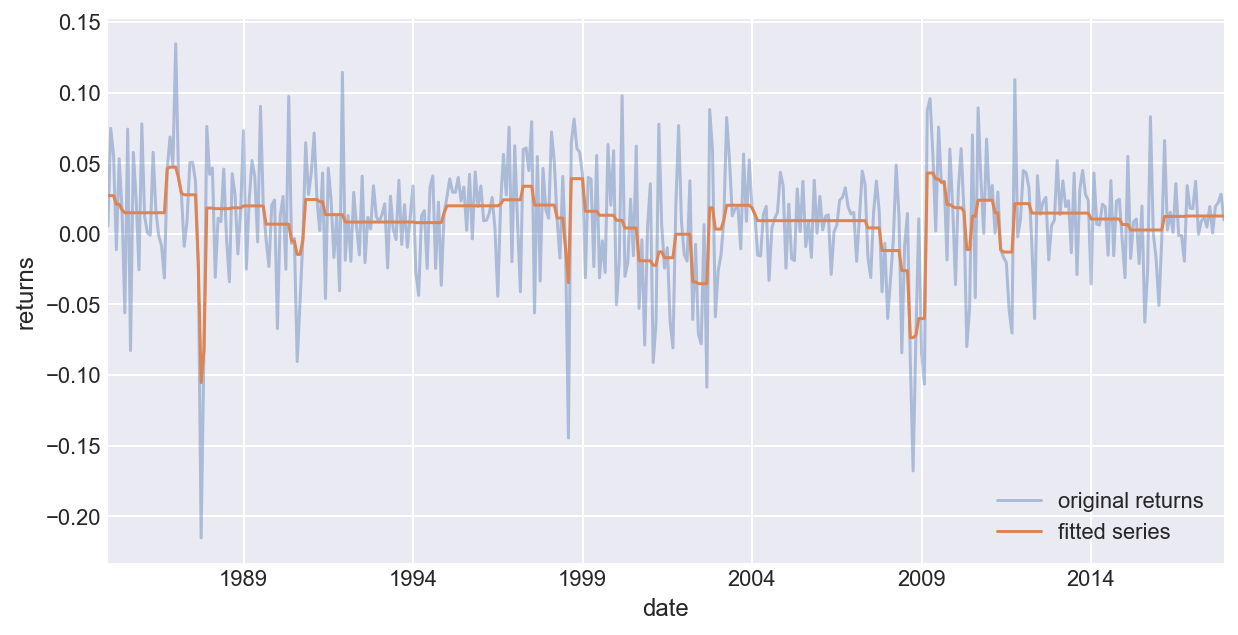

In [476]:
ax = mla.trend_filtering_plot(sp500["rets"], lambda_value=lambda_value, figx=10, figy=5)

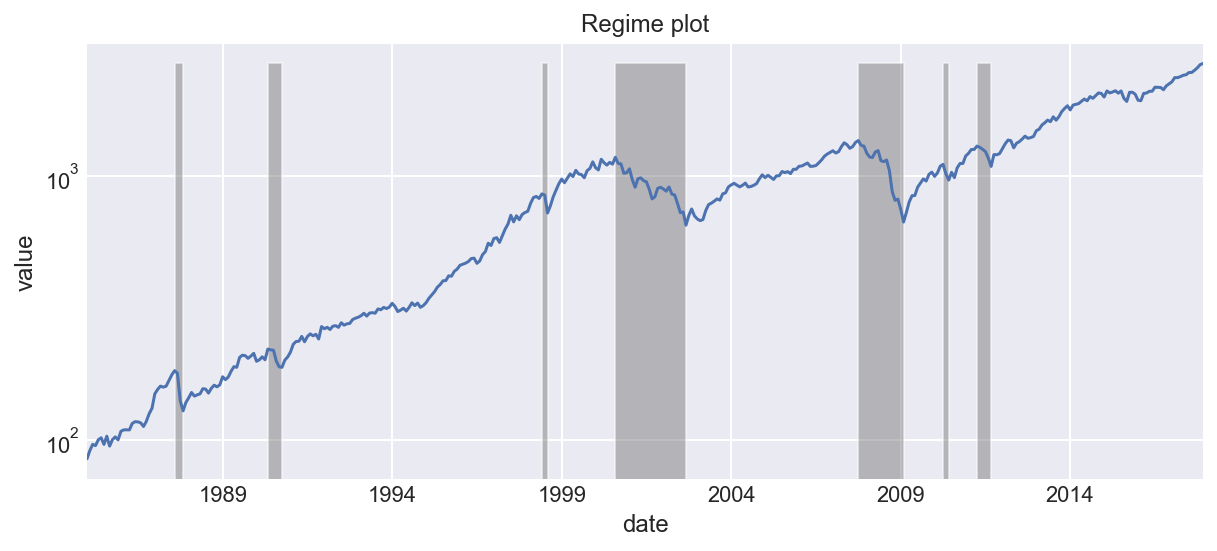

In [482]:
ax = mla.plot_regime_color(sp500["value"], lambda_value=lambda_value, figx=10, figy=4)

In [684]:
regimes = rets.iloc[:,range(9,12)]
regime_name = "Regime-5"

In [685]:
rets = rets.iloc[:,range(8)]
rets_g = rets[regimes[regime_name]==1]
rets_c = rets[regimes[regime_name]==-1]

In [689]:
ann_rets = erk.annualize_rets(rets, periods_per_year=12)
ann_rets

US Equities       0.114126
World Equities    0.089324
US Treasuries     0.063357
High Yield        0.088982
Real Estate       0.091857
Commodities       0.040027
Corp Bonds        0.074893
T-bill            0.034262
dtype: float64

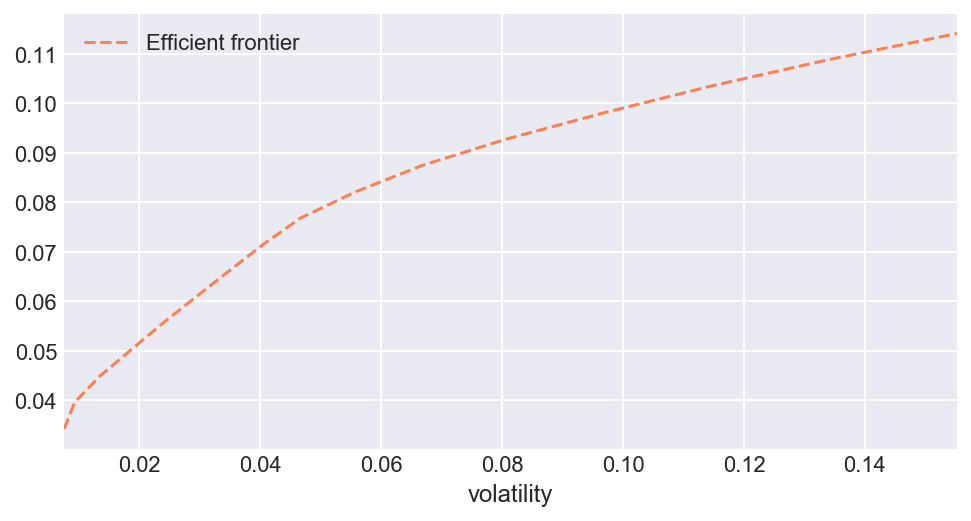

In [690]:
# plot the efficient frontier (single-regime)
df = erk.efficient_frontier(16, rets, rets.cov(), periods_per_year=12, iplot=True)

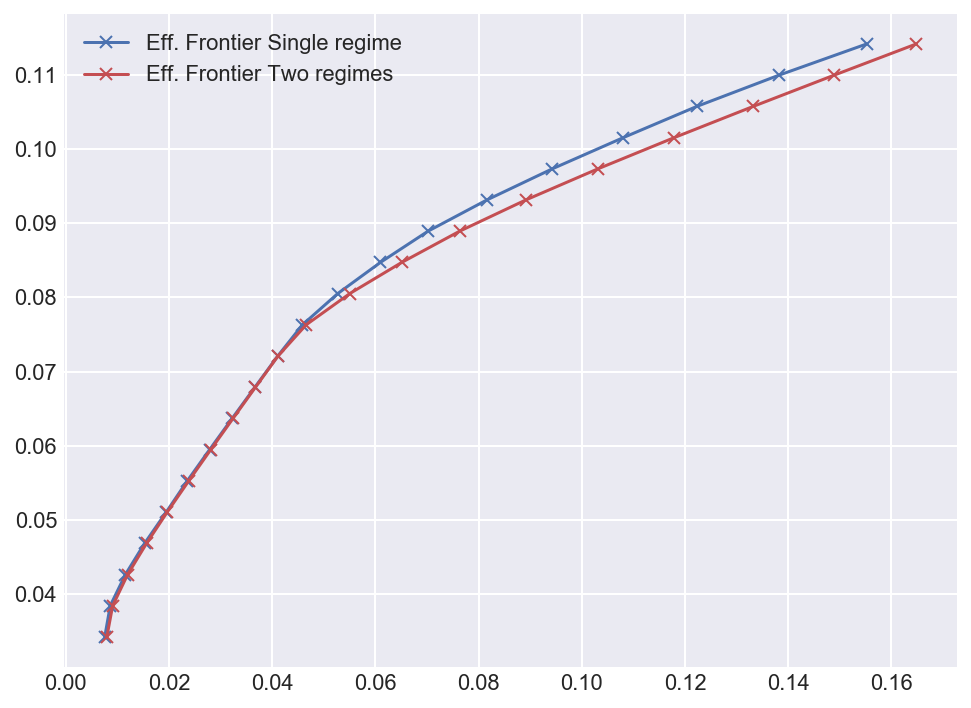

In [691]:
# compute the efficient frontier with two-regimes 
ann_rets_g = erk.annualize_rets(rets_g, periods_per_year=12)
ann_rets_c = erk.annualize_rets(rets_c, periods_per_year=12)
ax = mla.efficient_frontier_two_regimes(rets, rets_g, rets_c, periods_per_year=12, n_ports=20, n_scenarios=10000, figx=8, figy=6)

### Simulate regime-based returns and portfolio wealth

In [782]:
n_years = 50
n_scenarios = 100
regime_name = "Regime-9"
r_all = mla.regime_based_simulated_rets(rets, rets_g, rets_c, regime=regimes[regime_name], periods_per_years=12, 
                                        n_years=n_years, n_scenarios=n_scenarios) #, rand_seed=777)

In [783]:
r_all.shape

(600, 8, 100)

In [784]:
# assuming fixed holdings
holdings = np.array([0.5, 0.2, 0.05, 0.1, 0.05, 0.0333, 0.3333, 0.03333])

# portfolio wealths 
portfolio_sim = mla.simulate_fund_wealth(r_all, rets.columns, holdings, start=100)

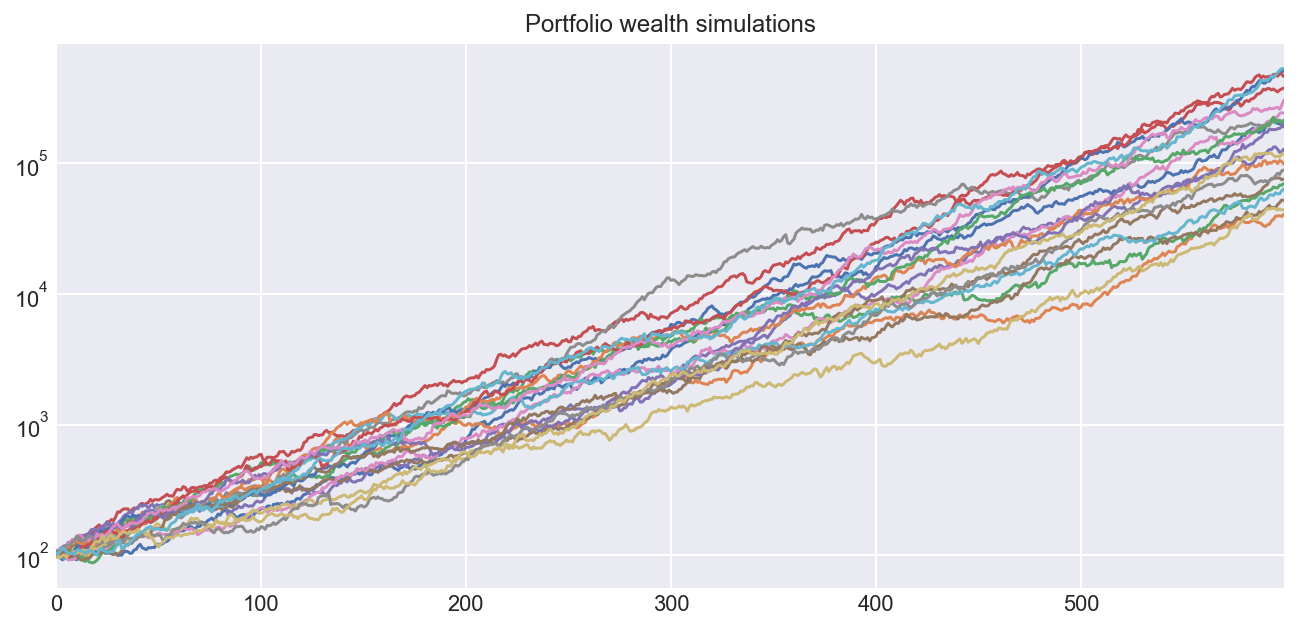

In [785]:
fig, ax = plt.subplots(1,1,figsize=(11,5))
# plot first 20 wealth
portfolio_sim.iloc[:,:20].plot(ax=ax, grid=True, logy=True, legend=False, title="Portfolio wealth simulations")
plt.show()

### Simulate portfolio wealth given original returns 

In [773]:
rets_orig = np.zeros((rets.shape[0], rets.shape[1], 1))
rets_orig[:,:,0] = rets.values

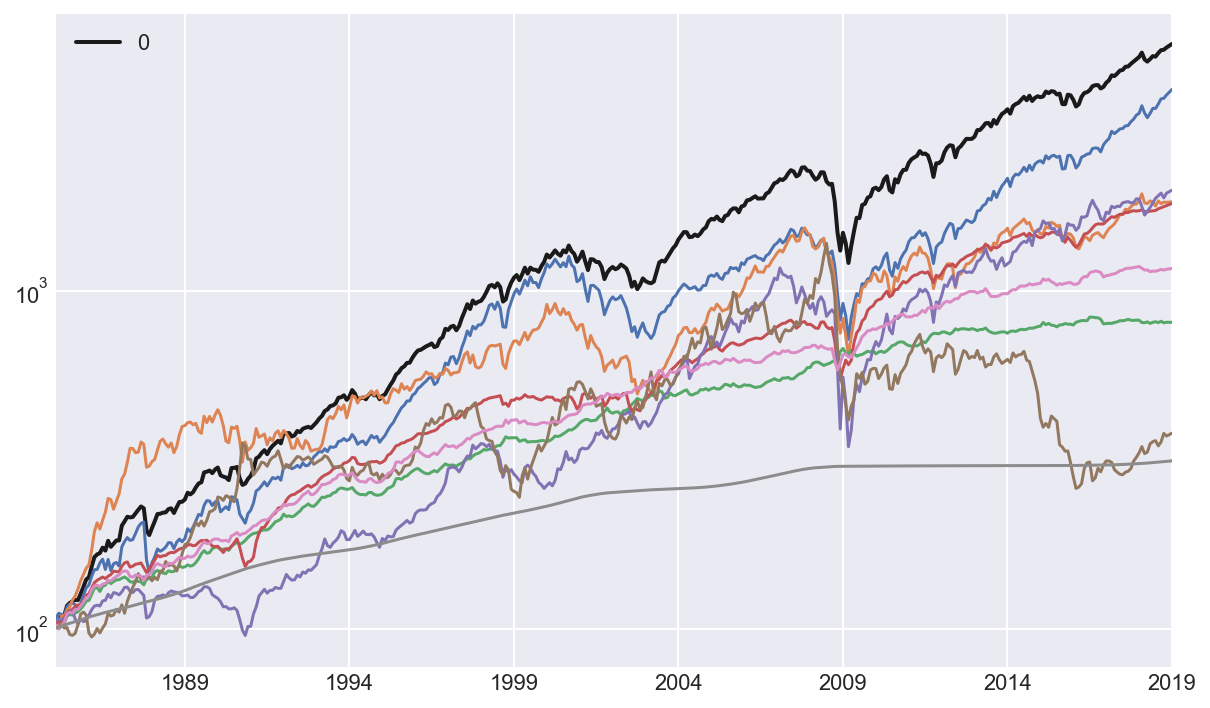

In [776]:
# assuming fixed holdings
holdings = np.array([0.5, 0.2, 0.05, 0.1, 0.05, 0.0333, 0.3333, 0.03333])

# portfolio wealths 
portfolio_sim = mla.simulate_fund_wealth(rets_orig, rets.columns, holdings, start=100)
portfolio_sim.index = rets.index

# plot
fig, ax = plt.subplots(1,1,figsize=(10,6))
portfolio_sim.plot(ax=ax, grid=True, logy=True, color="k", linewidth=2, label="Portfolio wealth simulations")
erk.compound_returns(rets,start=100).plot(ax=ax, grid=True, logy=True, legend=False)
plt.show()

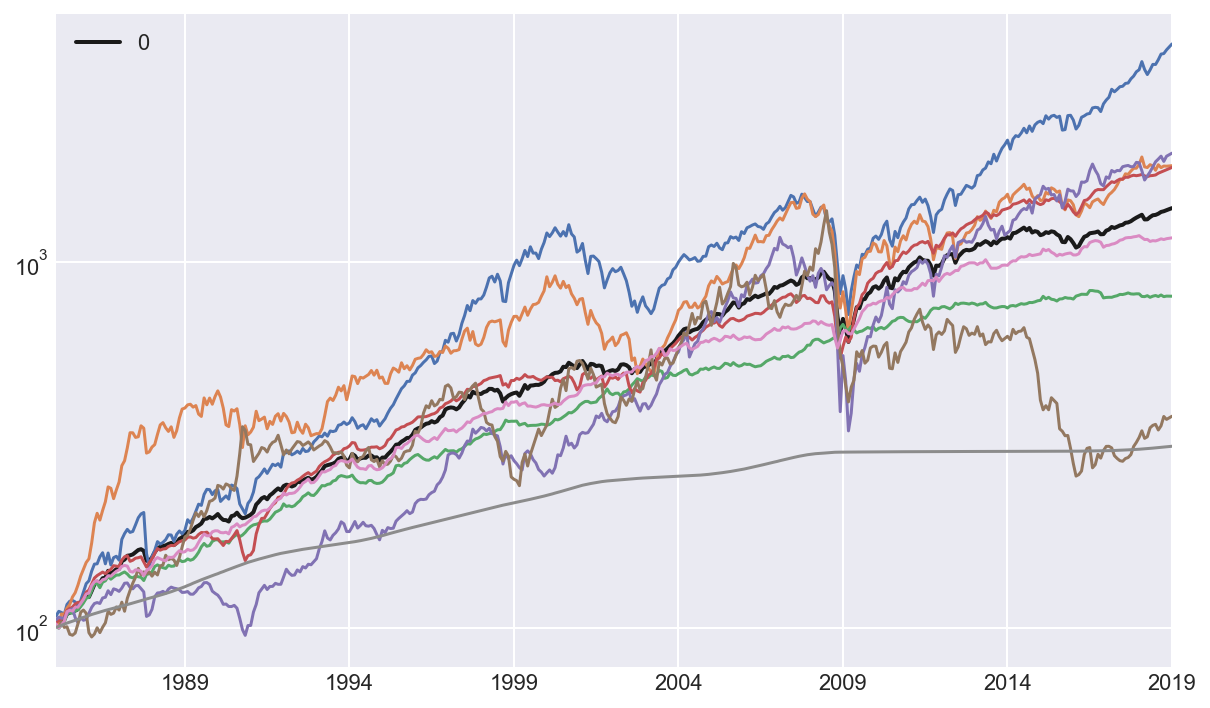

In [777]:
# assuming fixed holdings: EW portfolio
holdings = np.repeat(1/8, 8) 

# portfolio wealths 
portfolio_sim = mla.simulate_fund_wealth(rets_orig, rets.columns, holdings, start=100)
portfolio_sim.index = rets.index

# plot
fig, ax = plt.subplots(1,1,figsize=(10,6))
portfolio_sim.plot(ax=ax, grid=True, logy=True, color="k", linewidth=2, label="Portfolio wealth simulations")
erk.compound_returns(rets,start=100).plot(ax=ax, grid=True, logy=True, legend=False)
plt.show()